In [7]:
import os
import pickle
import gymnasium as gym
import jax.numpy as jnp
import jax.nn as nn
import jax.random as random
import numpy as np
import optax
import seaborn as sns
import matplotlib.pyplot as plt

from gymnasium import wrappers
from jax import grad, jit, Array, lax
from flax import linen
from numpy.typing import NDArray
from utils.common import KeyGenerator
%matplotlib inline 

In [8]:
class NeuralNet(linen.Module):
    hidden_size: int = 128
    action_space: int = 2
    @linen.compact
    def __call__(self, x):
        x = linen.Dense(self.hidden_size, kernel_init=linen.initializers.xavier_normal())(x)
        x = linen.relu(x)
        logits = linen.Dense(self.action_space, kernel_init=linen.initializers.xavier_normal())(x)
        value = linen.Dense(1, kernel_init=linen.initializers.xavier_normal())(x)
        return logits, value

In [9]:
gamma = 0.99
seed = 0
lr = 0.01
num_envs = 10

key_gen = KeyGenerator(seed)

venv = gym.make_vec('CartPole-v1', num_envs=num_envs)
print('observation shape:', venv.observation_space.shape)
print('action shape:', venv.action_space.shape)

neural_net = NeuralNet()
opt = optax.adam(lr)
obs, info = venv.reset(seed=seed)

# initialize the states
params = neural_net.init(key_gen()[0], obs)
opt_state = opt.init(params)


@jit
def policy(params: dict, obs: NDArray, key: Array):
    logits, _ = neural_net.apply(params, obs)
    action = random.categorical(key=key, logits=logits, axis=1)
    return action


def collect_transitions(obs: NDArray, params: dict, steps: int = 50):
    assert obs.shape[0] == num_envs
    obs_arr = []
    act_arr = []
    rew_arr = []
    next_obs_arr = []
    done_arr = []
    for _ in range(steps):
        key = key_gen()[0]
        act = policy(params, obs, key)
        next_obs, rew, terminated, truncated, info = venv.step(np.asarray(act))
        # flatten and process the transitions
        for env_idx in range(num_envs):
            obs_arr.append(obs[env_idx])
            act_arr.append(act[env_idx])
            rew_arr.append(rew[env_idx])
            if terminated[env_idx]:
                done_arr.append(1)
                next_obs_arr.append(info['final_observation'][env_idx])
            elif truncated[env_idx]:
                done_arr.append(0)
                next_obs_arr.append(info['final_observation'][env_idx])
            else:
                done_arr.append(0)
                next_obs_arr.append(next_obs[env_idx])
        obs = next_obs

    obs_arr = np.array(obs_arr)
    act_arr = np.array(act_arr)
    rew_arr = np.array(rew_arr)
    next_obs_arr = np.array(next_obs_arr)
    done_arr = np.array(done_arr)

    return (obs_arr, act_arr, rew_arr, next_obs_arr, done_arr), obs


def compute_loss(params: dict,
                 transitions: tuple):

    obs, act, rew, next_obs, done = transitions
    logits, values = neural_net.apply(params, obs)
    _, next_values = lax.stop_gradient(neural_net.apply(params, next_obs))
    # compute the td errors
    deltas = rew + gamma * next_values * (1 - done) - values
    # normalize the deltas
    mean_deltas = jnp.mean(deltas)
    std_deltas = jnp.std(deltas)
    deltas_normalized = (deltas - mean_deltas) / (std_deltas + 1e-8)
    # compute the critic loss
    critic_loss = deltas_normalized ** 2
    # compute the actor loss
    log_probs = nn.log_softmax(logits, axis=1)
    actor_loss = - log_probs[np.arange(len(act)), act] * lax.stop_gradient(deltas_normalized)
    # compute the total loss
    total_loss = jnp.mean(actor_loss + critic_loss)

    aux_info = dict(actor_loss=jnp.mean(actor_loss),
                    critic_loss=jnp.mean(critic_loss),
                    total_loss=total_loss,
                    mean_deltas=mean_deltas)

    return total_loss, aux_info


grad_fn = grad(compute_loss, has_aux=True)


@jit
def update(params: dict,
           opt_state: dict,
           transitions: tuple):
    gradient, aux_info = grad_fn(params, transitions)
    updates, next_opt_state = opt.update(gradient, opt_state)
    next_params = optax.apply_updates(params, updates)
    return next_params, next_opt_state, aux_info


def evaluate(params: dict, seed: int, num_eps=10):
    env_eval = gym.make('CartPole-v1')
    env_eval = wrappers.RecordEpisodeStatistics(env_eval)
    cum_rews = []
    for i in range(num_eps):
        obs, info = env_eval.reset(seed=seed+i)
        terminated, truncated = False, False
        while not terminated and not truncated:
            key = key_gen()[0]
            act = policy(params, obs[None], key)
            obs, rew, terminated, truncated, info = env_eval.step(
                np.asarray(act[0]))
        cum_rews.append(info['episode']['r'])
    env_eval.close()
    return np.mean(cum_rews)


observation shape: (10, 4)
action shape: (10,)


step: 10, mean return: 13.5
step: 20, mean return: 13.399999618530273
step: 30, mean return: 17.600000381469727
step: 40, mean return: 14.300000190734863
step: 50, mean return: 24.799999237060547
step: 60, mean return: 19.200000762939453
step: 70, mean return: 20.299999237060547
step: 80, mean return: 25.100000381469727
step: 90, mean return: 25.700000762939453
step: 100, mean return: 21.899999618530273
step: 110, mean return: 19.100000381469727
step: 120, mean return: 20.299999237060547
step: 130, mean return: 28.5
step: 140, mean return: 29.200000762939453
step: 150, mean return: 27.899999618530273
step: 160, mean return: 21.200000762939453
step: 170, mean return: 23.0
step: 180, mean return: 19.399999618530273
step: 190, mean return: 15.600000381469727
step: 200, mean return: 12.600000381469727
step: 210, mean return: 10.199999809265137
step: 220, mean return: 9.399999618530273
step: 230, mean return: 10.699999809265137
step: 240, mean return: 10.800000190734863
step: 250, mean retu

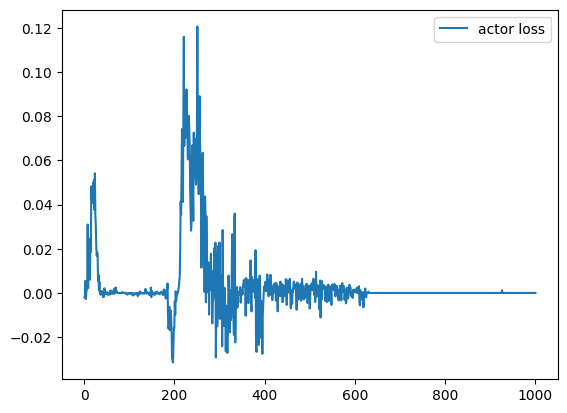

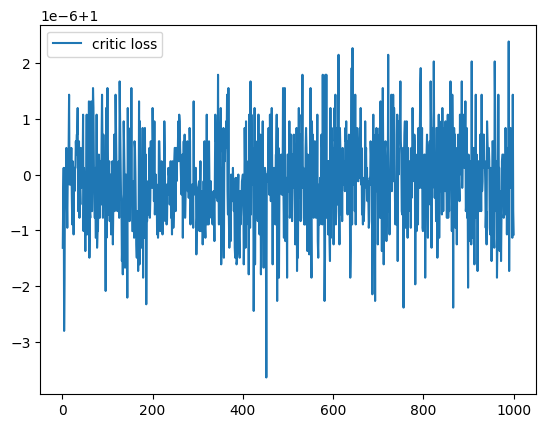

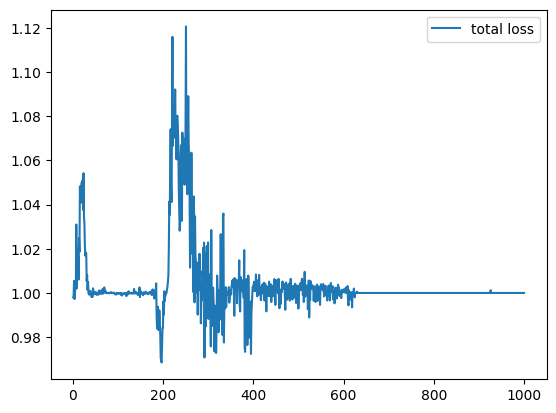

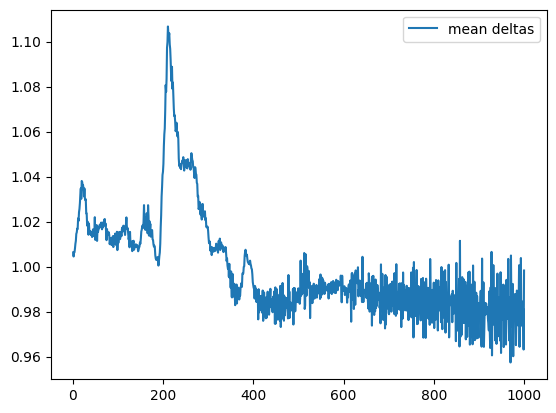

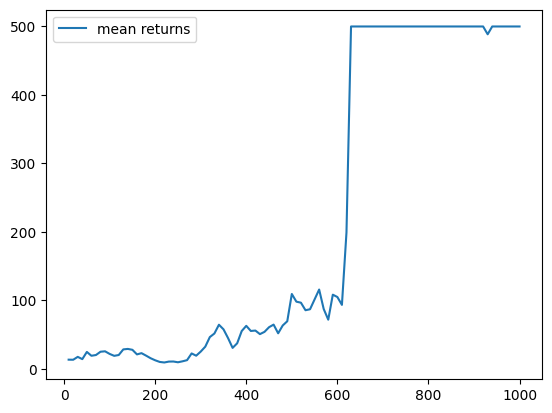

In [10]:
# training
steps = 1000
actor_losses = []
critic_losses = []
total_losses = []
mean_deltas = []

eval_freq = 10
mean_returns = []
eval_steps = []

best_params = params
best_mean_ret = 0
for step in range(1, steps + 1):
    transitions, obs = collect_transitions(obs, params)
    params, opt_state, aux_info = update(params, opt_state, transitions)

    actor_losses.append(aux_info['actor_loss'])
    critic_losses.append(aux_info['critic_loss'])
    total_losses.append(aux_info['total_loss'])
    mean_deltas.append(aux_info['mean_deltas'])

    if step % eval_freq == 0:
        eval_steps.append(step)
        mean_ret = evaluate(params, seed=step)
        mean_returns.append(mean_ret)
        if mean_ret > best_mean_ret:
            best_mean_ret = mean_ret
            best_params = params
        print(f'step: {step}, mean return: {mean_ret}')

x = np.arange(1, steps+1)

plt.figure()
plt.plot(x, actor_losses, label='actor loss')
plt.legend()

plt.figure()
plt.plot(x, critic_losses, label='critic loss')
plt.legend()

plt.figure()
plt.plot(x, total_losses, label='total loss')
plt.legend()

plt.figure()
plt.plot(x, mean_deltas, label='mean deltas')
plt.legend()

plt.figure()
plt.plot(eval_steps, mean_returns, label='mean returns')
plt.legend()

ckpt = dict(best_params=best_params,
            latest_params=params,
            opt_state=opt_state)

ckpt_path = os.path.join('checkpoints', 'latest_ckpt.pkl')
with open(ckpt_path, 'wb') as f:
    pickle.dump(ckpt, f)

venv.close()

In [11]:
# generate video
with open(ckpt_path, 'rb') as f:
    ckpt = pickle.load(f)
params = ckpt['best_params']

test_env = gym.make('CartPole-v1', render_mode='rgb_array', max_episode_steps=500)
test_env = wrappers.RecordVideo(env=test_env, 
                                video_folder='./video',
                                name_prefix='AC',
                                disable_logger=True)
test_seed = 42
obs, info = test_env.reset(seed=test_seed)
terminated, truncated = False, False
while not terminated and not truncated:
    key = key_gen()[0]
    act = policy(params, obs[None], key)
    obs, rew, terminated, truncated, info = test_env.step(np.asarray(act[0]))
test_env.close()